In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

!pip install orthojax

# Using Polynomial Chaos to Propagate Uncertainty through an ODE

Let $\Xi$ be a random variable.
Consider the stochastic ODE:

$$
\dot{x} = f(t,x;\Xi),
$$

with initial conditions:

$$
x_0 = x(0;\Xi).
$$

Notice that the solution at time $t$ is a random variable that is a function of $\Xi$:

$$
X_t = x(t;\Xi).
$$

So, $X_t$ is in the Hilbert space $L^2(\Xi)$.

Take the orthonormal polynomial basis of $L^2(\Xi)$, $\{e_0, e_1,\dots\}$.
We can expand $X_t$ in this basis:

$$
X_t = \sum_{i=0}^\infty \alpha_i(t) e_i(\Xi).
$$

Our goal is to show that the coefficients $\alpha_i$ satisfy an initial value problem.
By solving that initial value problem, we can compute them for all times.

We start by taking the ODE and taking the inner product of both sides with $e_i$.
From the left hand side, we have:

$$
\langle \dot{X}_t, e_i \rangle = \langle \sum_{j=0}^\infty \dot{\alpha}_j(t) e_j,e_i \rangle = \sum_{j=0}^\infty \dot{\alpha}_j(t) \langle e_j, e_i \rangle = \dot{\alpha}_i(t).
$$

This is very convenient.
The right hand side is a bit more complicated.
First, we need to think of $f(t,X_t;\Xi)$ as a function of $\Xi$.
This will introduce a dependence on the coefficients $a = (a_0,a_1, \dots)$.
We write:

$$
g(t, a;\Xi) = f\left(t, \sum_{i=0}^\infty a_i e_i(\Xi);\Xi\right).
$$

Now, think of $g(t,a;\cdot)$ as a function of $\Xi$ for fixed $t$ and $a$ and take the inner product with $e_i$:

$$
g_i(t,a) = \langle g(t,a;\cdot), e_i \rangle.
$$

Equating the left and right hand sides, we have:

$$
\dot{\alpha}_i(t) = g_i(t,\alpha),
$$

for $i=0,1,\dots$.

The initial conditions are given by:

$$
\alpha_i(0) = \langle x_0, e_i \rangle.
$$

In practice we truncate the infinite sum at some $N$ and solve the system of ODEs:

$$
\dot{\alpha}_i(t) = g_i(t,\alpha), \quad i=0,1,\dots,N,
$$

with initial conditions:

$$
\alpha_i(0) = \langle x_0, e_i \rangle, \quad i=0,1,\dots,N.
$$

One, typically increases $N$ until the solution converges.

```{note}
Another name for what we have done above is Galerkin projection.
There is really nothing special about the basis $\{e_0,e_1,\dots\}$.
It was orthonormal polynomials, but it could have been any basis.
```

The fact that we have used an orthonormal basis enables us to quickly characterize the statistics of $X_t$.
For example, the mean is:

$$
\mu_t = \mathbb{E}[X_t] = \langle X_t, e_0 \rangle = \alpha_0(t).
$$

The variance is:

$$
\sigma_t^2 =  \|X_t\|^2 - \mu_t^2 = \sum_{i=1}^N \alpha_i(t)^2.
$$

# Example: Propagating Uncertainty through a Pendulum

Consider the exponential decay equation:

$$
\dot{x} = -(0.5 + 0.1\Xi) x
$$

with initial condition:

$$
x_0 = x(0) = 1,
$$

and random variable $\Xi$ uniformly distributed on $[-1,1]$.

Let's construct the polynomials:

In [2]:
import orthpol as orp

degree = 5
poly = orp.make_legendre_polynomial(degree)

Now, let's code up the left hand side of the ODE:

In [34]:
# Theta here are other parameters that are not random. None used here.
f = lambda t, x, xi, theta: -(0.5 + 0.1 * xi) * x

The initial conditions are the trivial function of $\Xi$:

In [4]:
x0 = lambda xi: 1.0

Now, we need to write code that makes the right hand side and the initial conditions of the dynamical system that governs the coefficients $\alpha_i$:

In [93]:
import jax.numpy as jnp
from jax import vmap, jit


def make_pc_problem(poly, f, x0, theta):
    # The quadrature rule used to compute inner products
    xis, ws = poly.quad

    # The polynomial basis functions on the collocation points
    phis = poly(xis)

    # The initial condition of the PC coefficients
    x0s = vmap(x0)(xis)
    a0 = jnp.einsum('i,ij,i->j', x0s, phis, ws)
    fv = vmap(f, in_axes=(None, 0, 0, None))
    
    # The right hand side of the PC ODE
    def rhs(t, a, theta_rhs):
        phis = theta_rhs[0]
        theta = theta_rhs[1:]
        xs = jnp.einsum('i,ni->n', a, phis)
        fs = f(t, xs, xis, theta)
        return jnp.einsum("i,ij,i->j", fs, phis, ws)
    
    return rhs, a0, (phis, theta)

Here is how to use the code:

In [95]:
rhs, a0, theta = make_pc_problem(poly, f, x0, None)

And now we have the code we need to solve an initial value problem using `Diffrax`:

In [96]:
from diffrax import diffeqsolve, Tsit5, ODETerm, SaveAt

solver = Tsit5()
saveat = SaveAt(ts=jnp.linspace(0, 10, 2000))
term = ODETerm(vector_field)
sol = diffeqsolve(
    term,
    solver,
    t0=0,                       
    t1=10,                      
    dt0=0.1,                    
    y0=a0,
    args=theta,
    saveat=saveat
)

Here are are the PC coefficients evolving over time:

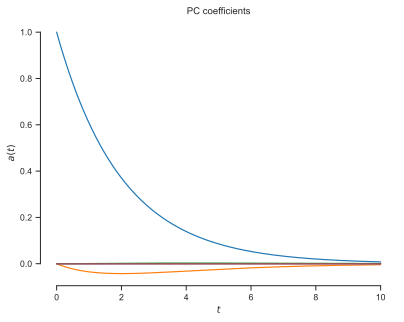

In [97]:
fig, ax = plt.subplots()
ax.plot(sol.ts, sol.ys)
ax.set(xlabel="$t$", ylabel="$a(t)$", title="PC coefficients")
sns.despine(trim=True)

Here are the statistics with PC:

In [98]:
import numpy as np

pc_mean = sol.ys[:, 0]
pc_var = np.sum(sol.ys[:, 1:] ** 2, axis=1)

Let's calculate the statistics using Monte Carlo and compare:

In [99]:
xis = -1.0 + 2.0 * np.random.rand(10_000)
true_solution = jit(vmap(lambda xi: x0(None) * jnp.exp(-(0.5 + 0.1 * xi) * sol.ts)))
true_ys = true_solution(xis)
mc_mean = jnp.mean(true_ys, axis=0)
mc_var = jnp.var(true_ys, axis=0)

Here is the comparison:

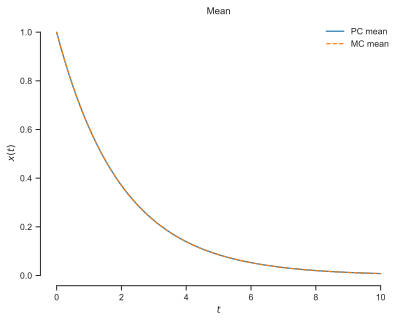

In [100]:
fig, ax = plt.subplots()
ax.plot(sol.ts, pc_mean, label="PC mean")
ax.plot(sol.ts, mc_mean, '--', label="MC mean")
ax.set(xlabel="$t$", ylabel="$x(t)$", title="Mean")
ax.legend(frameon=False)
sns.despine(trim=True)

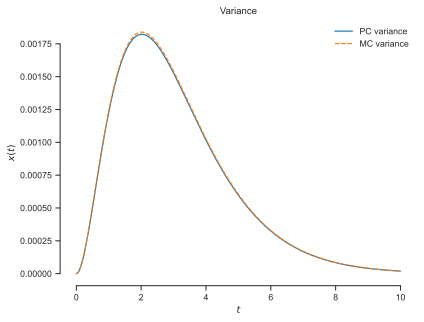

In [85]:
fig, ax = plt.subplots()
ax.plot(sol.ts, pc_var, label="PC variance")
ax.plot(sol.ts, mc_var, '--', label="MC variance")
ax.set(xlabel="$t$", ylabel="$x(t)$", title="Variance")
ax.legend(frameon=False)
sns.despine(trim=True)

Notice, that polynomial chaos model we have created can also serve as a parametric form of the solution of the stochastic ODE.
We can evaluate it at any $\Xi$ like this:

In [115]:
def pc_sol(xis):
    return jnp.einsum("ti,ni->tn", sol.ys, poly(xis))

Here are some samples:

[Text(0.5, 0, '$t$'), Text(0, 0.5, '$x(t)$'), Text(0.5, 1.0, 'PC solution')]

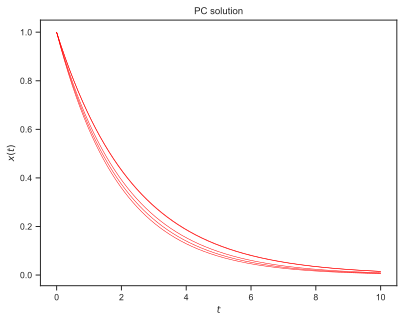

In [118]:
xis = -1.0 + 2.0 * np.random.rand(5)
fig, ax = plt.subplots()
ax.plot(sol.ts, pc_sol(xis), 'r', lw=0.5)
ax.set(xlabel="$t$", ylabel="$x(t)$", title="PC solution")